In [1]:
!pip install torch transformers

In [2]:
import torch
import numpy as np
from scipy.special import softmax
from tqdm import tqdm

In [3]:
from google.colab import drive
import pandas as pd
from IPython.display import display
from google.colab import drive
drive.mount('/content/drive')
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/data/processed/random_selected_articles_summaries_gpt_ner.csv'
df = pd.read_csv(csv_file_path)

Mounted at /content/drive


In [4]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [5]:
def score_article(article):
    # Tokenize the input article
    inputs = tokenizer(article, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the logits and apply softmax to get probabilities
    scores = outputs.logits[0].numpy()
    scores = softmax(scores)

    # Get the sentiment label
    sentiment = np.argmax(scores)

    # Define sentiment labels
    labels = ['Negative', 'Neutral', 'Positive']

    return labels[sentiment], scores

# Initialize a list to store results
results = []

# Loop through articles and score them
for _, article in tqdm(df.iterrows()):
    # Score the cleaned article
    article_predicted_class, article_class_probabilities = score_article(article['cleaned_article'])

    # Score the summary
    summary_predicted_class, summary_class_probabilities = score_article(article['ner_summary'])

    # Append results to the list
    results.append({
        "Article Title": article['title'],  # Assuming you want to use the article's title
        "Article Predicted Class": article_predicted_class,
        "Article Class Probabilities": article_class_probabilities,
        "GPT Predicted Class": summary_predicted_class,
        "GPT Class Probabilities": summary_class_probabilities
    })

# Convert the results to a DataFrame
df = pd.DataFrame(results)

# Display the results in tabular format
display(df)


293it [10:54,  2.23s/it]


,Article Title,Article Predicted Class,Article Class Probabilities,GPT Predicted Class,GPT Class Probabilities
0,Poland abortion: Polish women look for help in...,Neutral,"[0.23114845, 0.7413644, 0.027487192]",Negative,"[0.5432266, 0.437263, 0.019510437]"
1,Hong Kong Cardinal advocates for promoting a c...,Neutral,"[0.008529484, 0.6685063, 0.32296422]",Neutral,"[0.015793087, 0.5897794, 0.39442754]"
2,Sex Education in the Philippines - The Borgen ...,Neutral,"[0.02856262, 0.86998713, 0.10145029]",Neutral,"[0.18731499, 0.7653183, 0.047366783]"
3,"When a fetal scan showed problems, she fled Id...",Neutral,"[0.21159485, 0.75820965, 0.030195499]",Negative,"[0.6569992, 0.33125272, 0.011748152]"
4,Prioritizing the Neglected Areas of SRHR in Ca...,Neutral,"[0.040123418, 0.88495696, 0.07491961]",Neutral,"[0.1328876, 0.76750076, 0.09961167]"
...,...,...,...,...,...
288,Pueblo Council decision on anti-abortion ordin...,Neutral,"[0.27193996, 0.6949884, 0.033071652]",Neutral,"[0.19503814, 0.7447515, 0.060210314]"
289,Louisiana House guts abortion bill that could ...,Neutral,"[0.16884208, 0.7375804, 0.09357756]",Neutral,"[0.36087704, 0.61387575, 0.025247298]"
290,Onslaught of new abortion restrictions looms i...,Neutral,"[0.1965225, 0.7741904, 0.02928704]",Neutral,"[0.40342382, 0.5810424, 0.015533789]"
291,Indiana abortion clinics stop providing aborti...,Neutral,"[0.11622474, 0.85728806, 0.026487224]",Negative,"[0.4989825, 0.4828785, 0.018139001]"


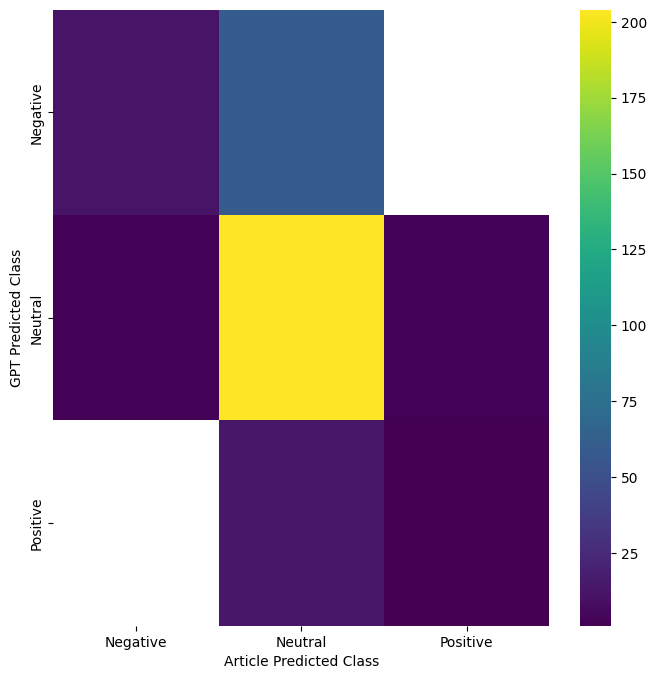

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['GPT Predicted Class'].value_counts()
    for x_label, grp in df.groupby('Article Predicted Class')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Article Predicted Class')
_ = plt.ylabel('GPT Predicted Class')

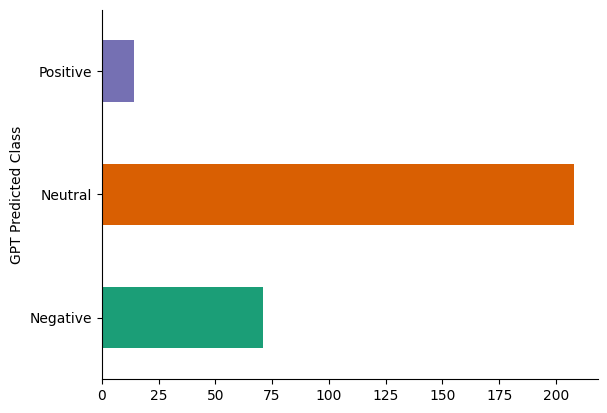

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('GPT Predicted Class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

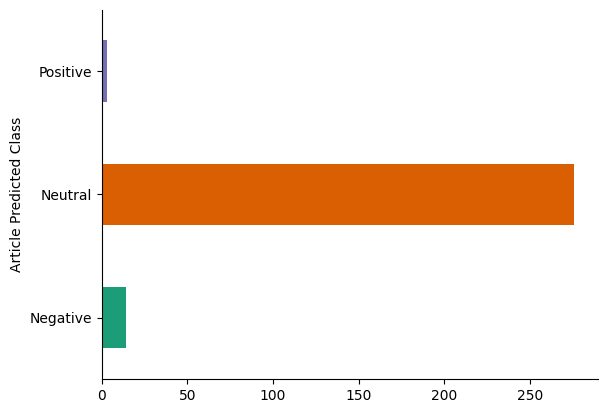

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Article Predicted Class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)